In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim, cuda
import torch.nn as nn

1. Create train and holdout folders, where each folder has the three classes as subfolders. Discuss in a markdown cell how many images you chose to have in each class' holdout folder. (Note: you can move images into the folders by hand if you don't want to write a script, but make sure you don't have the same images in train and holdout). Make sure all the class names are the same across folders. Now repeat the process for train and validation, so that you have a train, validation, and holdout folders at the same directory level. Discuss how/why you chose what's in your holdout.

I created 3 folders; Dogs_Holdout, Dogs_Train, and Dogs_Validation.  Within each of those folders, I have 3 subfolders; Great_Dane, Norfolk_Terrier, and Norwich_Terrier.  For each class/dog breed, I chose to put the first 10% of the images into the holdout folder, the second 10% of the images into the validation folder, and the remaining 80% into the train folder.  This is normally the percentage that we use to spit a dataset into train/holdout/validation.

2. Define a list of image transformations to be used during training, passing them to transforms.Compose(). Discuss why you think these transformations might help.

In [2]:
train_transformations = [
    transforms.Resize(size=[224,224]),
	transforms.RandomRotation(degrees=90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(), # randomly changes brightness, contrast, saturation
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
]

train_images = datasets.ImageFolder(root="Dogs_Train", transform=transforms.Compose(train_transformations))

Firstly, resizing all the images to the standard size of 224x224 is helpful so that they can all be on the same scale.  Then, I chose to perform random flips and rotation, just to add variety to the images.  Some dogs may be facing different directions, so it is important for the model to recognize the dogs from all angles.  The color jitter may also be helpful because I'm sure not all the photos were taken in the same lighting, so it is important for the model to pick up on certain colors or textures in different lighting situations.

3. Repeat the step above for test and validation transformations.

In [3]:
test_hold_transformations = [
    transforms.Resize(size=[224,224]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #make sure these nums are right
]
validation_images = datasets.ImageFolder(root="Dogs_Validation", transform=transforms.Compose(test_hold_transformations))
holdout_images = datasets.ImageFolder(root="Dogs_Holdout", transform=transforms.Compose(test_hold_transformations))


4. Correctly set up DataLoaders for the three folders (train, validation, holdout). Discuss what options you chose for these loaders, and why (including batch size, shuffling, and dropping last).

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_images, shuffle=True, batch_size=32, drop_last = False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_images, shuffle=True, batch_size=32, drop_last = False)
holdout_loader = torch.utils.data.DataLoader(dataset=holdout_images, shuffle=True, batch_size=32, drop_last = False)

We have a small datase, so I decided to go with a small batch size.  Batch sizes should be a power of 2, so I chose 32.  I chose drop_last to be false so that it will not drop the last incomplete batch.  We already have a small sample size, so I wouldn't want to drop a whole batch.

5. Instantiate any pre-trained ImageNet model. Discuss why you chose it amongst the others.

In [5]:
import torchvision.models as models
model = models.resnet18(pretrained=True)

ResNet18 is a convolutional neural network that is 18 layers deep.  You can load a pretrained version of the network to train and classsify images into object categories.  Residual neural networks apply identity mapping, which means the input to a layer is passed directly to another layer.  I chose this particular model because it is trained on more than 1 million images and it is known to produce good results when classifying images into categories.

6. Write code to freeze/unfreeze the pretrained model layers

In [6]:
#https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2
for param in model.parameters(): # freeze some maybe?
    param.requires_grad = False

7. Replace the head of the model with sequential layer(s) to predict our three classes.

In [7]:
import torch.nn as nn
#making a custom classifier
model.fc = nn.Linear(512, 3, bias=True) #inputs = num images in train
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

8. What activation function did you use in the step above? Why?

I used ReLu since it is already used by resnet.  Using ReLu during training is fast and has advantages such as sparsity and a reduced likelihood of vanishing gradient.

9. Did you use dropout in the step above? Why or why not?

No, I did not use dropout.  The model I have chosen, resnet, does not utilize dropout, so I did not include it.

10. Did you use batch normalization in the step above? Why or why not?

For the same reasons as above, I didn't include batch normalization.

11. Choose and instantiate an optimizer. Discuss your choice.

In [8]:
from torch import optim
optimizer = torch.optim.Adam(model.parameters())

I chose to go with the Adam Class.  From what I have gathered, it seems that Adam is a very popular optimizer and combines the properties of the Adadelta and RMSprop optimizers into one and tends to perform well on most problems.

12. Choose and instantiate a loss function. Discuss your choice.

In [9]:
loss_func = nn.CrossEntropyLoss()

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
I chose to use CrossEntropyLoss to asess the performance of the network.  It is the default loss function to use for multi-class classification problems, and we have 3 classes in this network.  It calculates a score that summerizes the average difference between the actual and predicted probability districbutions for all classes in the problem.

13. Write code that places the model on the GPU, if it exists, otherwise using the CPU.

In [10]:
move_to_gpu = cuda.is_available()
if move_to_gpu:
    model = model.to('cuda')


14. Correctly set up your model to train over 20+ epochs (if GPU) or 2+ epochs (if CPU).

In [11]:
epochs = 20
training_losses = []
validation_losses = []
training_accuracies = []
valid_accuracies = []
epoch_list = []

15. Correctly set up your model to use your batches for training.
16. Correctly make predictions with your model (the predictions can be wrong).
17. Correctly call your loss function and back-propagate its results.
18. Use the optimizer correctly to update weights/gradients.
19. Correctly record training losses for each epoch.
20. Correctly set up validation at each epoch.
21. Correctly record validation losses for each epoch.
22. Correctly record training and validation accuracies for each epoch
23. Write code that places the model on the GPU, if it exists, otherwise using the CPU.

In [12]:
for epoch in range(epochs):
    training_loss = 0
    valid_loss = 0
    
    training_accuracy = 0
    valid_accuracy = 0
    
    model.train()
    for images, labels in train_loader:
        if move_to_gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        #Make predictions with model
        predictions = model(images)
        #Call loss function and back-propagate its results.
        loss = loss_func(predictions, labels)
        loss.backward()
        #Use the optimizer correctly to update weights/gradients.
        optimizer.step()
        #Record training losses for each epoch.
        training_loss += loss.item()
        
        
        # Calculate accuracy by finding max log probability
        _, pred = torch.max(predictions, dim=1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        #Training accuracy
        training_accuracy += accuracy.item()
        
        
    #Correctly set up validation at each epoch.
    for images, labels in validation_loader:
        predictions = model(images)
        loss = loss = loss_func(predictions, labels)
        #record validation losses for each epoch.
        valid_loss += loss.item()
        
        # Calculate accuracy by finding max log probability
        _, pred = torch.max(predictions, dim=1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        #Training accuracy
        valid_accuracy += accuracy.item()
    
    epoch_list.append(epoch)
        
    #record training and validation loss for each epoch
    training_losses.append(training_loss/len(train_loader))
    validation_losses.append(valid_loss/len(validation_loader))
    
    #record training and validation accuracies for each epoch
    training_accuracies.append(training_accuracy/len(train_loader))
    valid_accuracies.append(valid_accuracy/len(validation_loader))
    
    print(f"\tTraining loss: {training_loss/len(train_loader)}")
    print(f"\tValidation loss: {valid_loss/len(validation_loader)}")

    

	Training loss: 0.9831161086375897
	Validation loss: 0.7904915809631348
	Training loss: 0.781135210624108
	Validation loss: 0.5766752064228058
	Training loss: 0.6640846958527198
	Validation loss: 0.49422846734523773
	Training loss: 0.6100761294364929
	Validation loss: 0.5095892548561096
	Training loss: 0.5654832972930028
	Validation loss: 0.42029060423374176
	Training loss: 0.5677131253939408
	Validation loss: 0.39867186546325684
	Training loss: 0.4953767405106471
	Validation loss: 0.4126570075750351
	Training loss: 0.4746035039424896
	Validation loss: 0.36696895956993103
	Training loss: 0.49627828139525193
	Validation loss: 0.37506377696990967
	Training loss: 0.4590642796112941
	Validation loss: 0.39287686347961426
	Training loss: 0.45242966826145464
	Validation loss: 0.34029823541641235
	Training loss: 0.450265666613212
	Validation loss: 0.41964875161647797
	Training loss: 0.45502057442298305
	Validation loss: 0.32041899859905243
	Training loss: 0.4230010234392606
	Validation loss: 0

24. Graph training versus validation loss using matplotlib.pyplot (or other). Was your model overfitting, underfitting, or neither?

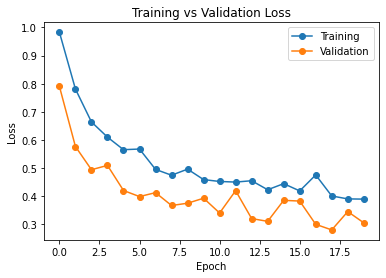

In [13]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, training_losses,marker="o")
plt.plot(epoch_list, validation_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Training vs Validation Loss')

plt.show()

25. Make a list of reasons why your model may have under-performed.

One possibility that the model underperforms could be due to the dataset itself.  Some of the images have multiple people/animals in one photo, so maybe the model gets confused on how to identify what is in the image.  Another reason the model may underperform is that there is an imbalance between the number of images for training for the different breeds, so the model may recognize one dog better than another.  Also, the sample size is pretty small, around 100-200 photos so that may not be a large enough sample size to train well.  Another thing that I can think of is that maybe a smaller batch size might help the model perform better.

26. Make a list of ways you could improve your model performance (you don't have to implement these unless you wan to).

Decrease batch size, adjust learning rate, change number of epochs, get more images of the dogs to increase smaple size, try different image transformations

27. Graph training versus validation accuracy using matplotlib.pyplot (or other). Score your model on its predictions on the holdout. Discuss why you think your results will or will not generalize.

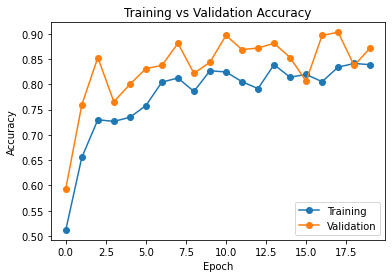

In [14]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, training_accuracies,marker="o")
plt.plot(epoch_list, valid_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Training vs Validation Accuracy')

plt.show()

Extra Credit: Discuss the paper in one paragraph.

This project uses neural networks to learn to identify three breeds of dogs.  CNNs are useful for this type of classification because they are able to recognize patterns in images.  Certain dogs have different visual traits.  However, great danes are very different looking compared to norwich and norfolk terriers, which look very alike.  Regular neural networks have an input layer, a hidden layer, and an output layer.  they contain neurons which are all interweaved between layers and have weights based on previous layers.  This isnt the best method of classifying images since there are no assumptions made about the data inputted into the network.  CNNs are better for classifying images since the neurons are only connected to nearby neurons and all have the same weight.  The data is also spatial.  The ReLu activation function which ensures non-linearlity as data passes through the layers.  I created a training process so that the model can learn on the images of the 3 breeds and then use what it learned to try to classify unseen images.  Based on the graphs, the accuracy of train and validation increasy pretty steeply until around the 7th epoch and then kind of hit a plateau.  Similarly, for the losses, the loss decreases pretty sharply until around the 7th epoch then plateaus.